# Imports
Imports and configurations are handled here as needed.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_rel

import warnings
warnings.filterwarnings("ignore")

# Data Preparation
Load the data from text files and preprocess it.

In [2]:
# base_path = "/blue/hcds_hackathon/hackathon_projects/lung_cancer_metabolomics/metabolite_data/"
base_path = "./data/"
data1_path = base_path + "ST000368_1.txt"
data2_path = base_path + "ST000369.txt"

In [3]:
# function to convert file to pandas dataframe
def process_data(data_path, metabolite_offset):
    with open(data_path) as f:
        lines = f.read().split("\n")

    ## the first line is patient IDs
    keys = lines[0].split("\t")
    # print(len(keys))

    ## the second line is clinical data for each patient ID (organ/cancer/smoker/gender)
    clinical_data = [x.split(" | ") for x in lines[1].split("\t")]
    clinical_data = [([y.split(":")[len(y.split(":")) - 1] for y in x]) for x in clinical_data]
    # print(len(clinical_data))

    result = dict(zip(keys, clinical_data))
    
    ## the remaining lines are metabolomics
    ## error, some lines are NA. figure out where NA should be removed when attaching metabolomics
    for n in range(2, len(lines)):
        split_metabolics = lines[n].split("\t")
        zipped = list(zip(keys, split_metabolics))
        for x in zipped:
            result[x[0]].append(x[1])

    ## remove these rows as they are column names/identifiers for metabolites and not informative 
    metabolites = result.pop("Metabolite_name")
    refmet_name = result.pop("RefMet_name")
    keys.remove("Metabolite_name")
    keys.remove("RefMet_name")

    ## create column names and generate a dataframe to return
    colnames = ["Organ", "Cancer", "Smoker", "Gender"]
    for x in metabolites[1:-1]:
        colnames.append(x)
        
    df = pd.DataFrame(result).T
    df.columns = colnames

    return df

df1 = process_data(data1_path, 2)
df2 = process_data(data2_path, 2)
combined_df = pd.concat([df1, df2])[(list(set(df1.columns) & set(df2.columns)))]

# combined_df.to_csv("metabolites.csv")
combined_df


,pyruvic acid,isoleucine,threonic acid,2-hydroxyvaleric acid,arachidonic acid,citrulline,2-hydroxyhippuric acid,asparagine,indole-3-acetate,heptadecanoic acid NIST,...,cholesterol,kynurenine,quinic acid,methanolphosphate,methionine sulfoxide,arachidic acid,indole-3-lactate,pipecolic acid,5-methoxytryptamine,uric acid
140225dlvsa44_1,2911,18014,951,1392,230,361,84,2168,632,306,...,59943,93,359,339,125,2291,365,260,314,9647
140226dlvsa30_1,148,34100,1010,1047,7348,1429,82,3462,1605,406,...,87805,189,207,525,352,1067,730,191,304,32608
140226dlvsa36_1,308,25723,947,876,9097,814,107,4609,585,1207,...,92716,227,544,406,506,748,466,1346,246,42896
140227dlvsa36_1,281,33773,2605,1170,18245,600,109,4160,2251,567,...,67235,247,1007,527,494,769,660,107,83,26146
140227dlvsa47_1,415,27941,1851,1658,7869,1431,103,5327,629,486,...,105437,190,1635,517,423,1032,648,117,744,29759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130730dlvsa12_1,991,32105,4635,641,579,459,55,3778,1070,250,...,34689,184,437,104,1167,761,462,645,473,10602
130730dlvsa25_1,2900,30381,1466,819,582,964,51,2594,543,233,...,12431,118,997,252,570,847,763,1760,79,8186
130730dlvsa43_1,2070,27662,958,1062,306,419,64,2837,763,378,...,23211,229,147,102,492,577,500,490,36,17379
130730dlvsa49_1,831,24763,5606,1363,699,793,49,3491,892,962,...,32886,205,135,193,999,879,387,533,586,11773


In [4]:
data = combined_df.copy()
data = data[data["Gender"] != "NA"]
data = data[data["Cancer"].isin(["Healthy", "Adenocarcinoma"])]

y = (data["Cancer"] == "Healthy").map({False: 1, True: 0})
X_metabolics = data.drop("Cancer", axis=1).drop(["Organ", "Smoker", "Gender"], axis=1)

X_clinical = data.drop("Cancer", axis=1).drop(["Organ"], axis=1)
X_clinical["Smoker"] = X_clinical["Smoker"].map({"Former": 0, "Current": 1})
X_clinical["Gender"] = X_clinical["Gender"].map({"F": 0, "M": 1})

def na_vals(X):
    X = X.replace("", np.nan)
    X = X.apply(pd.to_numeric)
    X = X.fillna(X.mean(numeric_only=True))
    return X

X_clinical = na_vals(X_clinical)
X_metabolics = na_vals(X_metabolics)

# Comparison of Model Performance - Clinical Data
Compare how the model performs when including clinical data and excluding clinical data.

Metabolomics only -> median accuracy: 0.598, max accuracy: 0.753, median recall: 0.615, max recall: 0.846
Clinical features -> median accuracy: 0.598, max accuracy: 0.722, median recall: 0.615, max recall: 0.846


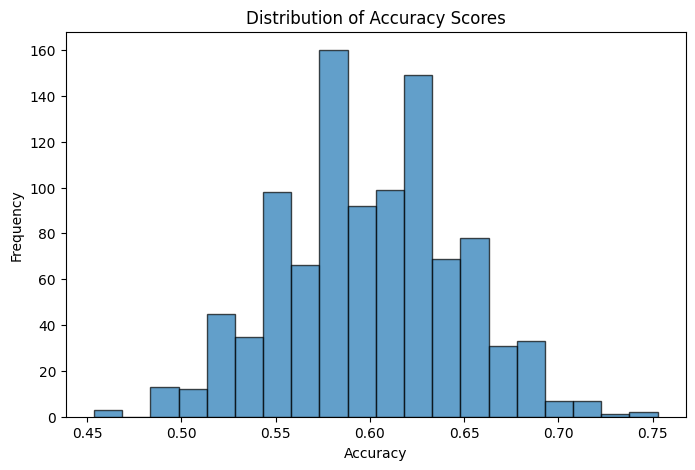

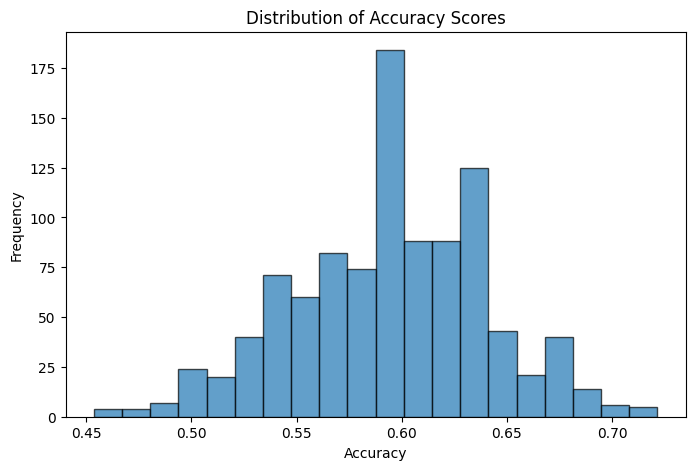

Metabolomics-only accuracies are significantly higher (t=7.380, p=0.0000)
One-sided paired t-test (recall, metab > clinical): t=4.834, p=0.0000
Metabolomics accuracy median=0.598, 95% CI [0.505, 0.691]
Clinical accuracy median=0.598, 95% CI [0.505, 0.681]


In [ ]:
scaler = StandardScaler()

count = 0
saved_model = None
prev_acc = 0

accuracy_list = []
recall_list = []
coef_list = []
acc2_list = []
recall2_list = []
coef2_list = []

while (count < 1000):
    count += 1
    ## metabolics
    X_train, X_test, y_train, y_test = train_test_split(
        X_metabolics, y, test_size=0.3, random_state=count, stratify=y
    )
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LinearSVC(random_state=0, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    accuracy_list.append(acc)
    recall_list.append(rec)
    coef_list.append(model.coef_[0])

    ## clinical data
    X_train, X_test, y_train, y_test = train_test_split(
        X_clinical, y, test_size=0.3, random_state=count, stratify=y
    )
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LinearSVC(random_state=0, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc2_list.append(acc)
    recall2_list.append(rec)
    coef2_list.append(model.coef_[0])

met_median = np.median(accuracy_list)
met_max = np.max(accuracy_list)
met_recall_median = np.median(recall_list)
met_recall_max = np.max(recall_list)
clin_median = np.median(acc2_list)
clin_max = np.max(acc2_list)
clin_recall_median = np.median(recall2_list)
clin_recall_max = np.max(recall2_list)

print(f"Metabolomics only -> median accuracy: {met_median:.4f}, max accuracy: {met_max:.4f}, median recall: {met_recall_median:.4f}, max recall: {met_recall_max:.4f}")
print(f"Clinical features -> median accuracy: {clin_median:.4f}, max accuracy: {clin_max:.4f}, median recall: {clin_recall_median:.4f}, max recall: {clin_recall_max:.4f}")

def plot_accuracies(acc_list):
    plt.figure(figsize=(8,5))
    plt.hist(acc_list, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.title("Distribution of Accuracy Scores")
    plt.show()

plot_accuracies(accuracy_list)
plot_accuracies(acc2_list)

# paired differences (test whether metabolomics > clinical)
t_stat, p_two_sided = ttest_rel(accuracy_list, acc2_list)
p_one_sided = (p_two_sided / 2) if t_stat > 0 else (1 - p_two_sided / 2)

if p_one_sided < 0.05:
    print(f"Metabolomics-only accuracies are significantly higher (t={t_stat:.4f}, p={p_one_sided:.4f})")
else:
    print(f"No significant difference favoring metabolomics over clinical (t={t_stat:.4f}, p={p_one_sided:.4f})")

# optional: test recall similarly
t_r, p2_r = ttest_rel(recall_list, recall2_list)
p1_r = (p2_r / 2) if t_r > 0 else (1 - p2_r / 2)
print(f"One-sided paired t-test (recall, metab > clinical): t={t_r:.4f}, p={p1_r:.4f}")

# optional: 95% CIs for the distributions
met_ci = np.percentile(accuracy_list, [2.5, 97.5])
clin_ci = np.percentile(acc2_list, [2.5, 97.5])
print(f"Metabolomics accuracy median={np.median(accuracy_list):.4f}, 95% CI [{met_ci[0]:.4f}, {met_ci[1]:.4f}]")
print(f"Clinical accuracy median={np.median(acc2_list):.4f}, 95% CI [{clin_ci[0]:.4f}, {clin_ci[1]:.4f}]")

In [9]:
def tune_model(X, y, param_grid, cv):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(max_iter=5000, dual=False))
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring={
            "accuracy": "accuracy",
            "recall": make_scorer(recall_score),
            "f1": make_scorer(f1_score)
        },
        refit="recall",
        cv=cv,
        n_jobs=-1
    )
    grid.fit(X, y)
    return grid

def extract_split_metrics(cv_results, metric_name, best_index, n_splits):
    split_keys = [f"split{i}_test_{metric_name}" for i in range(n_splits)]
    split_scores = [cv_results[key][best_index] for key in split_keys]
    return np.mean(split_scores), np.max(split_scores)

param_grid = {
    "clf__C": np.logspace(-4, 3, 10),
    "clf__class_weight": [None, "balanced"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
met_grid = tune_model(X_metabolics, y, param_grid, cv)
clin_grid = tune_model(X_clinical, y, param_grid, cv)

def report_results(grid, label, n_splits):
    best_idx = grid.best_index_
    mean_acc, max_acc = extract_split_metrics(grid.cv_results_, "accuracy", best_idx, n_splits)
    mean_rec, max_rec = extract_split_metrics(grid.cv_results_, "recall", best_idx, n_splits)
    mean_f1, max_f1 = extract_split_metrics(grid.cv_results_, "f1", best_idx, n_splits)
    best_params = grid.best_params_
    print(f"{label} -> tuned accuracy (mean/max): {mean_acc:.4f}/{max_acc:.4f}, tuned recall (mean/max): {mean_rec:.4f}/{max_rec:.4f}, tuned f1 (mean/max): {mean_f1:.4f}/{max_f1:.4f}")
    print(f"{label} best params (recall-optimized): {best_params}")

report_results(met_grid, "Metabolomics only", cv.get_n_splits())
report_results(clin_grid, "Clinical features", cv.get_n_splits())

Metabolomics only -> tuned accuracy (mean/max): 0.6717/0.7031, tuned recall (mean/max): 0.6889/0.8000, tuned f1 (mean/max): 0.6912/0.7467
Metabolomics only best params (recall-optimized): {'clf__C': np.float64(1000.0), 'clf__class_weight': 'balanced'}
Clinical features -> tuned accuracy (mean/max): 0.6564/0.7188, tuned recall (mean/max): 0.6662/0.8286, tuned f1 (mean/max): 0.6736/0.7632
Clinical features best params (recall-optimized): {'clf__C': np.float64(27.825594022071257), 'clf__class_weight': None}


# Hyperparameter Tuning
Explore whether tuning Linear SVM hyperparameters improves accuracy and recall for each feature set.

# Comparison of Model Performance - Metabolics
Compare how the model performs when using a variable number of metabolics to predict.

In [7]:
X = X_metabolics
coef_df = pd.DataFrame(coef_list, columns=X.columns)
coef_df['accuracy'] = accuracy_list
coef_df.sort_values(by='accuracy', ascending=False)

coef_70 = coef_df[coef_df['accuracy'] >= 0.7]

coef_summary = coef_70.drop(columns='accuracy').agg(['mean', 'std']).T
coef_summary['abs_mean'] = coef_summary['mean'].abs()
coef_summary = coef_summary.sort_values(by='abs_mean', ascending=False)

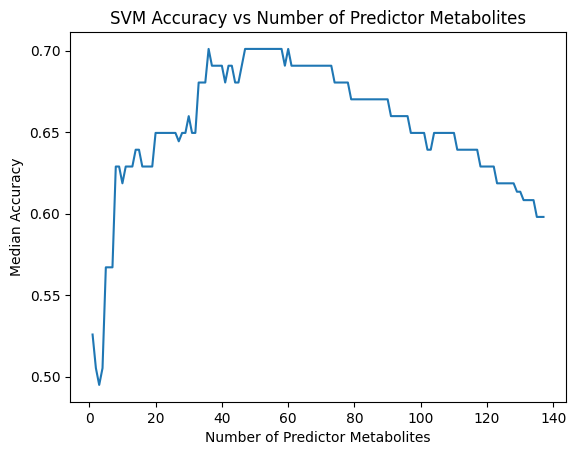

In [ ]:
median_accuracy =  []
idx = [x+1 for x in range(len(X.columns))]

for n in range(len(X.columns)):
    n = n + 1
    # print("TOP",n,"METABOLICS")
    topn = coef_summary.head(n).index.values
    X_n = X_metabolics[topn]
    
    seed = 42
    scaler = StandardScaler()
    count = 0
    saved_model = None
    prev_acc = 0
    accuracy_list = []
    coef_list = []
    
    while (count < 500):
        # if (count % 1000 == 0):
        #     print(count)
        count += 1
        X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=count)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        model = LinearSVC(random_state=0, max_iter=5000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracy_list.append(acc)
        coef_list.append(model.coef_[0])

        if (acc > prev_acc):
            saved_model = model
            prev_acc = acc
            print("Models evaluated:", count)
            print("Accuracy:", accuracy_score(y_test, y_pred))
            # print("\nClassification Report:\n", classification_report(y_test, y_pred))
            
    
    median_accuracy.append(np.median(accuracy_list))
    # plt.figure(figsize=(8,5))
    # plt.hist(accuracy_list, bins=20, edgecolor='k', alpha=0.7)
    # plt.xlabel("Accuracy")
    # plt.ylabel("Frequency")
    # plt.title("Distribution of Accuracy Scores with top " + str(n) + " metabolics")
    # plt.show()

plt.plot(idx, median_accuracy)
plt.title("SVM Accuracy vs Number of Predictor Metabolites")
plt.xlabel("Number of Predictor Metabolites")
plt.ylabel("Median Accuracy")
plt.show()

# Top-50 Metabolites: Accuracy, Recall, and F1
We evaluate LinearSVC using the top 50 metabolites (by absolute mean coefficient from the earlier Monte Carlo run). We report median and max across repeated stratified splits and plot a bar chart for each metric.

Top-50 -> median acc: 0.7010, max acc: 0.8247; median recall: 0.7115, max recall: 0.8654; median f1: 0.7238, max f1: 0.8283


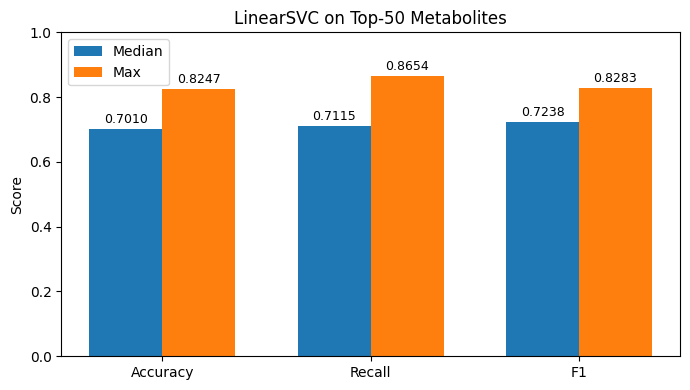

In [10]:
# Build the top-50 metabolite list from the existing coef_summary
top50 = coef_summary.head(50).index.values

# Evaluate with repeated stratified splits
accs, recs, f1s = [], [], []
scaler = StandardScaler()
for seed in range(1, 501):
    Xn = X_metabolics[top50]
    X_train, X_test, y_train, y_test = train_test_split(
        Xn, y, test_size=0.3, random_state=seed, stratify=y
    )
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    clf = LinearSVC(random_state=0, max_iter=5000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

# Summaries
med_acc, max_acc = np.median(accs), np.max(accs)
med_rec, max_rec = np.median(recs), np.max(recs)
med_f1, max_f1 = np.median(f1s), np.max(f1s)
print(f"Top-50 -> median acc: {med_acc:.4f}, max acc: {max_acc:.4f}; median recall: {med_rec:.4f}, max recall: {max_rec:.4f}; median f1: {med_f1:.4f}, max f1: {max_f1:.4f}")

# Bar chart: median vs max for each metric
metrics = ["Accuracy", "Recall", "F1"]
median_vals = [med_acc, med_rec, med_f1]
max_vals = [max_acc, max_rec, max_f1]
x = np.arange(len(metrics))
w = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - w/2, median_vals, width=w, label="Median")
plt.bar(x + w/2, max_vals, width=w, label="Max")
plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("LinearSVC on Top-50 Metabolites")
plt.legend()
for i,(m, M) in enumerate(zip(median_vals, max_vals)):
    plt.text(i - w/2, m + 0.01, f"{m:.4f}", ha="center", va="bottom", fontsize=9)
    plt.text(i + w/2, M + 0.01, f"{M:.4f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()